In [3]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import argparse
import random

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'pfs_pc_pattern_similarity_210101_random'


sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot_data import MyPlotData

# ap = argparse.ArgumentParser()
# ap.add_argument("--min_length", type=int, default=4)
# ap.add_argument("--max_dist", type=int, default=125)
# ap.add_argument("--n_random", type=int, default=20)
# ap.add_argument("--n_sample", type=int, default=10000)
# config = ap.parse_args()
max_dist = 150
min_length = 6
n_random = 20
n_sample = 10000


from weight_database import WeightDatabase
weightdb = WeightDatabase()

weightdb.load_syn_db('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/pfs/gen_210101_setup01_syndb_threshold_10_coalesced_filtered_10.gz')
weightdb.load_touch_db(
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/purkinje/db_pf_contacts_201224.gz',
    max_dist=max_dist
    )

postsyns = list(weightdb.get_presyn_ids())
hist = defaultdict(list)

def calc_pattern_similarity(weightdb, type='Data'):
    mpd = MyPlotData()
    processed = set()
    n = 0
    random.seed(0)
    while n < n_sample:
        pc0 = postsyns[int(random.random()*len(postsyns))]
        pc1 = postsyns[int(random.random()*len(postsyns))]
        if pc0 == pc1:
            continue
        if (pc0, pc1) in processed:
            continue
        processed.add((pc0, pc1))
        processed.add((pc1, pc0))
        if len(weightdb.get_shared_presyns(pc0, pc1)) < min_length:
            continue
        score = weightdb.calc_pattern_similarity(pc0, pc1)
        # if score >= 0.7:
        #     print(f'{pc0} and {pc1}: {score}')
        mpd.add_data_point(
            score=score,
            type=type,
            )
        n += 1
        hist[type].append(score)
    print(f'Num samples: {n}')
    return mpd


mpd_data = calc_pattern_similarity(weightdb)

for i in range(n_random):
    print(i)
    random.seed(i)
    weightdb_random = weightdb.randomize_connectivity(type='presyn', global_rate=True)
    mpd_random = calc_pattern_similarity(weightdb_random, type='Random')



Num samples: 10000
0
Num samples: 10000
1
Num samples: 10000
2
Num samples: 10000
3
Num samples: 10000
4
Num samples: 10000
5
Num samples: 10000
6
Num samples: 10000
7
Num samples: 10000
8
Num samples: 10000
9
Num samples: 10000
10
Num samples: 10000
11
Num samples: 10000
12
Num samples: 10000
13
Num samples: 10000
14
Num samples: 10000
15
Num samples: 10000
16
Num samples: 10000
17
Num samples: 10000
18
Num samples: 10000
19
Num samples: 10000


In [4]:

import scipy
fout_name = f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_n_{n_random}'
with open(f'{script_n}_results', 'w') as fout:
    for foutt in [fout, sys.stdout]:
        print(scipy.stats.ttest_ind(hist['Data'], hist['Random']), file=foutt)
        print(scipy.stats.ranksums(hist['Data'], hist['Random']), file=foutt)
        print(scipy.stats.mannwhitneyu(hist['Data'], hist['Random'], alternative='greater'), file=foutt)
        print(scipy.stats.ks_2samp(hist['Data'], hist['Random']), file=foutt)


Ttest_indResult(statistic=1.6752707381679086, pvalue=0.09388261282159983)
RanksumsResult(statistic=1.6338754445177464, pvalue=0.10228500672865881)
MannwhitneyuResult(statistic=1009666160.5, pvalue=0.05006300875842789)
KstestResult(statistic=0.009159999999999946, pvalue=0.39878319792950123)


Height: 4, Aspect: 1.0


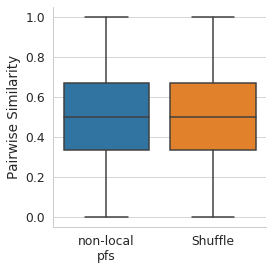

In [10]:


mpd_all = MyPlotData()
mpd_all.append(mpd_data)
mpd_all.append(mpd_random)

import compress_pickle
compress_pickle.dump(
    (mpd_data,
        mpd_random),
    f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_db.gz',)


importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    y="score",
    x="type",
    # ylim=[.30, .70],
    context='paper',
    kind='box',
    # add_swarm=True,
    xticklabels=['non-local\npfs', 'Shuffle'],
    height=4,
    width=4,
    y_axis_label='Pairwise Similarity',
    # x_axis_label='# of synapses per connection',
    save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )

